# Import Statements

In [456]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.functions import split
import pyspark.sql.functions as f
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

from pyspark.sql.functions import lit

# Prepare Training Data

In [458]:
spark = SparkSession \
    .builder \
    .appName("recommend-ML") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df=spark.read.options(delimiter='|').csv('test2_new.txt', header=False)
#df.printSchema()
df = df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "recommendation")

df1 = df.selectExpr("cast(userID as integer) userID",
    "cast(trackID as integer) trackID",
    "cast(recommendation as integer) recommendation")
#df1.printSchema()
cols = df1.columns
df1.show(6)

+------+-------+--------------+
|userID|trackID|recommendation|
+------+-------+--------------+
|200031|  30877|             1|
|200031|   8244|             1|
|200031| 130183|             0|
|200031| 198762|             0|
|200031|  34503|             1|
|200031| 227283|             0|
+------+-------+--------------+
only showing top 6 rows



In [460]:
numericCols = ['userID','trackID']
stages = []
assemblerInputs = numericCols 
assembler = VectorAssembler(inputCols = assemblerInputs,outputCol='features')
stages += [assembler]

In [461]:
label_stringIdx = StringIndexer(inputCol = 'recommendation',outputCol = 'label')
stages += [label_stringIdx]

In [462]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df1)
df1 = pipelineModel.transform(df1)
selectedCols = ['label','features'] + cols
df1 = df1.select(selectedCols)
df1.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- recommendation: integer (nullable = true)



# Prepare Testing Data

In [ ]:
df_final = spark.read.options(delimiter='|').csv('testTrack_hierarchy.txt', header=False)
#df_final.printSchema()
df_final = df_final.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "TrackID")

cols2 = ("_c2","_c3")
df_final = df_final.drop(*cols2)

#DF_FINAL CONTAINS USERID, TRACKID, AND ALL 0'S FOR THE RECOMMENDATION 
df_final = df_final.withColumn("Predictor",lit(0))


df_final = df_final.selectExpr("cast(userID as integer) userID",
    "cast(TrackID as integer) TrackID",
    "cast(Predictor as integer) Predictor")

df_final.show(6)

In [ ]:
cols2 = df_final.columns

numericCols2 = ['userID','TrackID']
stages2 = []
assemblerInputs2 = numericCols2 
assembler2 = VectorAssembler(inputCols = assemblerInputs2,outputCol='features')
stages2 += [assembler2]


label_stringIdx2 = StringIndexer(inputCol = 'Predictor',outputCol = 'label')
stages2 += [label_stringIdx2]

pipeline = Pipeline(stages = stages2)
pipelineModel2 = pipeline.fit(df_final)
df_final = pipelineModel2.transform(df_final)
selectedCols2 = ['label','features'] + cols2
df_final = df_final.select(selectedCols2)
df_final.printSchema()

# Split Training into Training and Validation

In [463]:
test = df1.where(df1["userID"].between(20031, 205246))
train = df1.where(df1["userID"].between(205249, 212234))

test = df1.where(df1["userID"].between(20031, 205246))

print("Train Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

test.show(5)




Train Dataset Count: 3600
Test Dataset Count: 2400
+-----+-------------------+------+-------+--------------+
|label|           features|userID|trackID|recommendation|
+-----+-------------------+------+-------+--------------+
|  1.0| [200031.0,30877.0]|200031|  30877|             1|
|  1.0|  [200031.0,8244.0]|200031|   8244|             1|
|  0.0|[200031.0,130183.0]|200031| 130183|             0|
|  0.0|[200031.0,198762.0]|200031| 198762|             0|
|  1.0| [200031.0,34503.0]|200031|  34503|             1|
+-----+-------------------+------+-------+--------------+
only showing top 5 rows



# Linear Regression Classifier Training 

In [465]:
lr = LogisticRegression(featuresCol = 'features',labelCol = 'label',maxIter = 3)
lrModel = lr.fit(train)

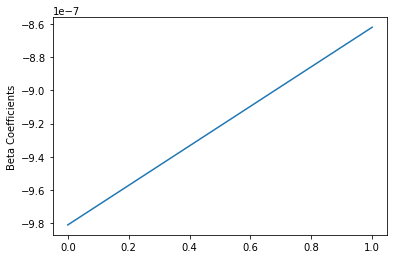

In [466]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


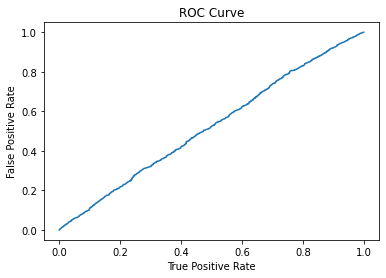

Trainign set areaUnderROC:0.5217462962962961


In [467]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Trainign set areaUnderROC:' +str(trainingSummary.areaUnderROC))

In [468]:
predictions = lrModel.transform(test)
predictions.select('userID','trackID','label','probability','rawPrediction','prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031|  30877|  1.0|[0.47220188059770...|[-0.1113072537020...|       1.0|
|200031|   8244|  1.0|[0.46734337619766...|[-0.1308127151228...|       1.0|
|200031| 130183|  0.0|[0.49356939404158...|[-0.0257238422297...|       1.0|
|200031| 198762|  0.0|[0.50834386941234...|[0.03337857630844...|       0.0|
|200031|  34503|  1.0|[0.47298076826942...|[-0.1081823121074...|       1.0|
|200031| 227283|  0.0|[0.51448554654435...|[0.05795840510631...|       0.0|
|200032| 218377|  0.0|[0.51256836708663...|[0.05028406088349...|       0.0|
|200032| 110262|  0.0|[0.48927887356154...|[-0.0428910799068...|       1.0|
|200032|  18681|  1.0|[0.46958336194595...|[-0.1218169696420...|       1.0|
|200032| 138493|  1.0|[0.49535983884438...|[-0.0185611774913...|       1.0|
|200032|  64

In [ ]:
sort_predictions = predictions.select('userID','trackID','label','probability','rawprediction','prediction').sort(col('userID').asc(),col('probability').desc())
sort_predictions.show(18)

# Linear Regression Classification Testing

In [470]:
predictions2 = lrModel.transform(df_final)

predictions2.select('userID','TrackID','Prediction').show(6)

+------+-------+----------+
|userID|TrackID|Prediction|
+------+-------+----------+
|199810| 208019|       0.0|
|199810|  74139|       1.0|
|199810|   9903|       1.0|
|199810| 242681|       0.0|
|199810|  18515|       1.0|
|199810| 105760|       1.0|
+------+-------+----------+
only showing top 6 rows



# Export Linear Regression Predictions

In [476]:
from pyspark.sql.functions import concat_ws,col

new=predictions2.select(concat_ws('_',predictions2.userID,predictions2.TrackID)
              .alias("TrackID"),"Prediction")

new.show(6)

#new.coalesce(1).write.csv("new")
#new.toPandas().to_csv('newLR.csv',header=True)

+-------------+----------+
|      TrackID|Prediction|
+-------------+----------+
|199810_208019|       0.0|
| 199810_74139|       1.0|
|  199810_9903|       1.0|
|199810_242681|       0.0|
| 199810_18515|       1.0|
|199810_105760|       1.0|
+-------------+----------+
only showing top 6 rows



# Decision Tree Classifier Training

In [295]:
dt = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'label',maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
sort_predictions = predictions.select('userID','trackID','label','probability','rawPrediction','prediction').sort(col('userID').asc(),col('probability').desc())
sort_predictions.show(18)

+------+-------+-----+--------------------+---------------+----------+
|userID|trackID|label|         probability|  rawPrediction|prediction|
+------+-------+-----+--------------------+---------------+----------+
|200031|  34503|  1.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200031| 227283|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200031|  30877|  1.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200031| 130183|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200031| 198762|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200031|   8244|  1.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200032| 138493|  1.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200032|  22820|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200032| 110262|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200032|  64167|  1.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|200032| 218377|  0.0|[0.48773551368645...|[1372.0,1441.0]|       1.0|
|20003

# Decision Tree Classifier Testing

In [482]:
predictions3 = dtModel.transform(df_final)


predictions3=predictions3.select(concat_ws('_',predictions3.userID,predictions3.TrackID)
              .alias("TrackID"),"Prediction")

predictions3.show(6)

predictions3.coalesce(1).write.csv("DTC_Final2")

+-------------+----------+
|      TrackID|Prediction|
+-------------+----------+
|199810_208019|       1.0|
| 199810_74139|       1.0|
|  199810_9903|       1.0|
|199810_242681|       0.0|
| 199810_18515|       1.0|
|199810_105760|       1.0|
+-------------+----------+
only showing top 6 rows



# Random Forest Classifier Training

In [296]:
rf = RandomForestClassifier(featuresCol = 'features',labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
sort_predictions = predictions.select('userId','trackID','label','probability','rawPrediction','prediction').sort(col('userID').asc(),col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userId|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 227283|  0.0|[0.55058545020718...|[11.0117090041436...|       0.0|
|200031|  30877|  1.0|[0.52429651888575...|[10.4859303777151...|       0.0|
|200031|  34503|  1.0|[0.52429651888575...|[10.4859303777151...|       0.0|
|200031| 130183|  0.0|[0.49369533012773...|[9.87390660255474...|       1.0|
|200031| 198762|  0.0|[0.43051185727636...|[8.61023714552730...|       1.0|
|200031|   8244|  1.0|[0.29856434019707...|[5.97128680394149...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



# Random Forest Classifier Testing

In [483]:
predictions4 = rfModel.transform(df_final)

predictions4=predictions4.select(concat_ws('_',predictions4.userID,predictions4.TrackID)
              .alias("TrackID"),"Prediction")
predictions4.coalesce(1).write.csv("RFC")

predictions4.show(6)



+-------------+----------+
|      TrackID|Prediction|
+-------------+----------+
|199810_208019|       1.0|
| 199810_74139|       0.0|
|  199810_9903|       0.0|
|199810_242681|       0.0|
| 199810_18515|       0.0|
|199810_105760|       0.0|
+-------------+----------+
only showing top 6 rows



# Gradient Boosted Tree Classifier Training

In [297]:
gbt = GBTClassifier(maxIter = 10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
sort_predictions = predictions.select('userId','trackID','label','probability','rawPrediction','prediction').sort(col('userID').asc(),col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userId|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.61973550218633...|[0.24421286008418...|       0.0|
|200031|  30877|  1.0|[0.53819618830849...|[0.07654150254904...|       0.0|
|200031|  34503|  1.0|[0.53819618830849...|[0.07654150254904...|       0.0|
|200031| 227283|  0.0|[0.52476654742665...|[0.04957366486375...|       0.0|
|200031|   8244|  1.0|[0.30106026900978...|[-0.4211270213915...|       1.0|
|200031| 198762|  0.0|[0.13233369160449...|[-0.9402402520294...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



# Gradient Boosted Tree Classifier Testing

In [485]:
predictions5 = gbtModel.transform(df_final)

predictions5=predictions5.select(concat_ws('_',predictions5.userID,predictions5.TrackID)
              .alias("TrackID"),"Prediction")
predictions5.coalesce(1).write.csv("GBTC")

predictions5.show(6)

+-------------+----------+
|      TrackID|Prediction|
+-------------+----------+
|199810_208019|       1.0|
| 199810_74139|       0.0|
|  199810_9903|       0.0|
|199810_242681|       0.0|
| 199810_18515|       0.0|
|199810_105760|       0.0|
+-------------+----------+
only showing top 6 rows

